In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import itertools as it
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as sla
import scipy.linalg as la
from collections import OrderedDict

import ccode.finite_system as tj
import ccode.tools as tl
import ccode.solvers as sl

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
a = 10e-9

In [4]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Spin orbit dependence

In [5]:
width = 80*a
center = [-width/4, width/4]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": width,
    "centers": center
}

In [6]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


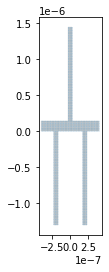

In [7]:
kwant.plot(trijunction);

In [8]:
key = 'mu_qd'
n = 6
system = [trijunction, f_params]
eigen = sl.general_solver([system], n)


def wrap(args):
    return eigen(*args)

In [37]:
# make parameters for each alpha
alphas = np.logspace(-1, 1, 50, endpoint=True)*3e-11
alphas_phases = []
for alpha in alphas:
    alphas_phases.append(sl.phase_params(key='alpha', param=alpha))

## Single example

In [10]:
args = list(it.product([0], alphas_phases[2]))
args_db = db.from_sequence(args, npartitions=20)

In [11]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1409a10d6d1f4fd98416dfa119d1af87/status


In [12]:
couplings, _, _ = tl.coupling_data(result)

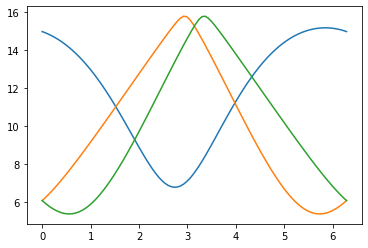

In [14]:
phases = np.linspace(0, 2*np.pi, 100)
for coupling in couplings:
    plt.plot(phases, 1e6*coupling)

In [23]:
couplings = np.array(couplings)
phases[np.argmax(couplings, axis=1)]/np.pi

array([1.85858586, 0.92929293, 1.07070707])

## SO dependence

In [38]:
phis = np.linspace(0, 2*np.pi, 100)
all_couplings = []
maxs = []

with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for phases in alphas_phases:
        args = list(it.product([0], phases))
        args_db = db.from_sequence(args, npartitions=20)
        result = args_db.map(wrap).compute()

        couplings, _, _ = tl.coupling_data(result)
        couplings = np.array(couplings)

        maxs.append(phis[np.argmax(couplings, axis=1)]/np.pi)
        all_couplings.append(couplings)

    maxs = np.array(maxs)
    all_couplings = np.array(all_couplings)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/6eec29b878b84a0bb4be8f4f4aa58987/status


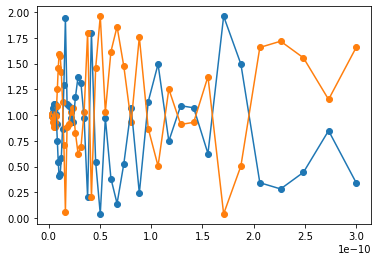

In [46]:
for level in maxs.T[1:]:
    plt.plot(alphas, level)
    plt.scatter(alphas, level)

# Nanowire position dependence

In [71]:
width = 80*a
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": width
}

In [72]:
n_geometries = 10
centers = np.linspace([width/4, -(width/4-10*a)], [width/4, -(width/4+10*a)], n_geometries)

In [73]:
tjs_width = []
for center in centers:
    geometry.update(centers=center)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs_width.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

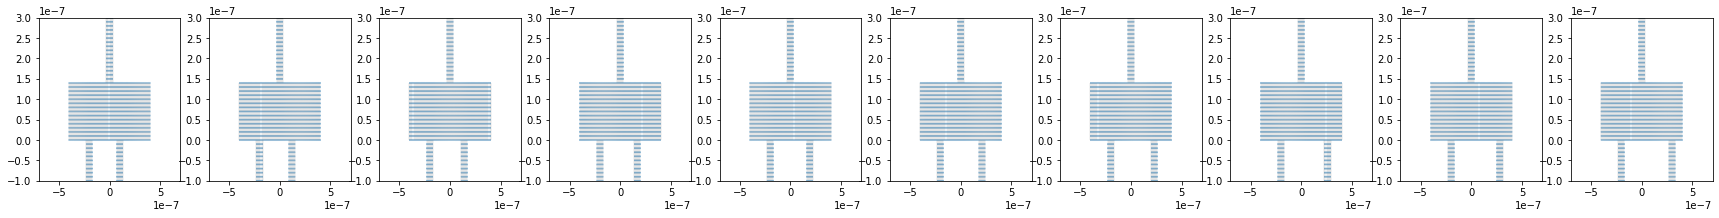

In [74]:
fig, ax = plt.subplots(ncols=n_geometries, nrows=1, figsize=(3*n_geometries, 3))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs_width[i][0], ax=axes)
    axes.set_ylim(-1e-7, 3e-7)
    axes.set_xlim(-7e-7, 7e-7)
    i += 1

In [75]:
key = 'mu_qd'
n = 6
eigen = sl.general_solver(tjs_width, n)


def wrap(args):
    return eigen(*args)

In [76]:
phases = sl.phase_params(key='sigma', param=0)
args = list(it.product(range(n_geometries), phases))
args_db = db.from_sequence(args, npartitions=20)

In [77]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/50a90de23fd0460caf1cd4e710530180/status


In [78]:
geometries_couplings = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, _ = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=0)
    geometries_couplings.append(couplings)

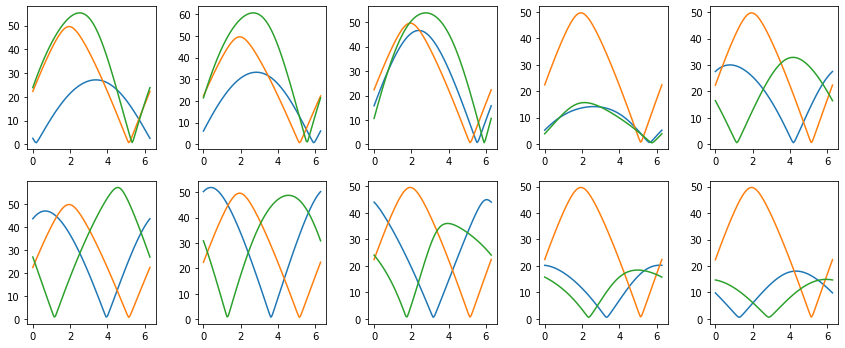

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
fig.tight_layout()
i = 0
for ax in axes.flatten():
    for coup in geometries_couplings[i]:
        ax.plot(phis, 1e6*coup)
    i += 1